# Cats and Dogs CNN with Data Augmentation

**Description:** Classify cats and dogs with a simple Convolutional Network<br>
                 
**Dataset:** Kaggle Dogs vs Cats dataset originally from Microsoft <br>
This version introduces Data Augmentation <br>
To perform data augmentation we use ImageDataGenerator from Keras

In [1]:
%matplotlib inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU, Dense, Softmax, Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

import numpy as np

import sys
sys.stderr = open('err.txt', 'w')

/home/jaumemanero/RL/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
I0000 00:00:1765809754.207360    8792 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:52:00.0, compute capability: 8.6
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
I0000 00:00:1765809790.659255    8912 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes bef

In [2]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(details.get("device_name", "Unknown GPU"))
else:
    print("No GPU detected")

2.20.0
NVIDIA GeForce RTX 3090


In [3]:
def count_files_in_directory(directory_path):
    """
    Count the total number of files directly in the given directory (excluding subdirectories).

    Parameters:
        directory_path (str): Path to the directory to count files in.

    Returns:
        int: Total number of files in the directory.
    """
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

#### **Directories**
Reads the Cats and Dogs dataset and loads in. Creating a PetImages folder with two subfolders Cat and Dog <bbr>
Don't repeat this step as with the files/folders created it may have some issues

In [4]:
# Loading the dataset from microsoft cloud - do it only once
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
#!unzip -q kagglecatsanddogs_5340.zip

#### **Cleaning data**
Just for security we delete some photos that may have the header corrupted.

In [5]:
num_skipped = 0
num_images = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            num_images += 1

print(f"Deleted {num_skipped} images.")
print(f"There are {num_images} clean images.")

Deleted 0 images.
There are 23412 clean images.


In [6]:
limit_class_images = 25000

num_skipped = 0
num_cats = 0
num_dogs = 0

folder_name = "Cat"
folder_path = os.path.join("PetImages", folder_name)
for fname in os.listdir(folder_path):                      
    fpath = os.path.join(folder_path, fname)
    num_cats += 1
    if num_cats > limit_class_images:
       os.remove(fpath)

cats = count_files_in_directory(folder_path)
        
folder_name = "Dog"
folder_path = os.path.join("PetImages", folder_name)
for fname in os.listdir(folder_path):                      
    fpath = os.path.join(folder_path, fname)
    num_dogs += 1
    if num_dogs > limit_class_images:
       os.remove(fpath)


dogs = count_files_in_directory(folder_path)

print(f"There are {cats} cats images and {dogs} images of dogs")

There are 11742 cats images and 11670 images of dogs


#### **Preparing the data**

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
<class 'tensorflow.python.data.ops.map_op._MapDataset'>


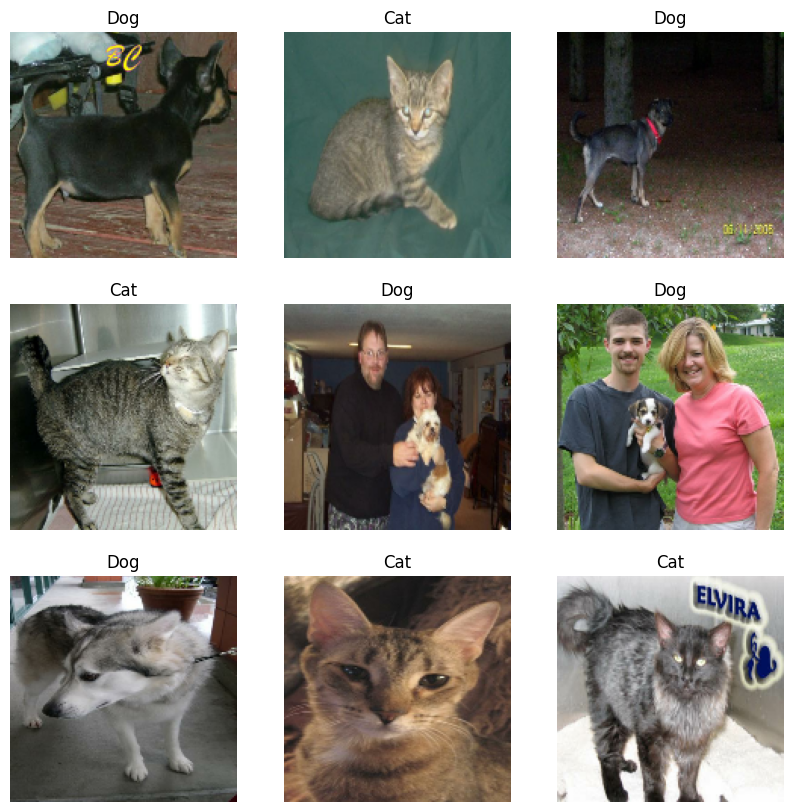

In [7]:
batch_size = 32
img_height = 150  
img_width  = 150
train_dir = './PetImages/'
class_names = ['Cat', 'Dog']

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'int',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'int',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check images

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
        
# Optional: Normalize pixel values (0-255 to 0-1)
normalization_layer = Rescaling(1./255)

train_dataset        = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset   = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
print(type(train_dataset))

#### **We perform the image data augmentation here is a bit tricky but efficient**

In [8]:
def custom_augmentation1(image, label):
    # Example augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return image, label

def custom_augmentation(image, label):
    # 1. Random horizontal and vertical flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # 2. Random rotation (angles in radians)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

    # 3. Random cropping or resizing
    crop_scale = tf.random.uniform([], 0.6, 0.8)  # Random scale for cropping

    # 4. Random brightness, contrast, and saturation adjustments
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)

    # 5. Random hue adjustment
    image = tf.image.random_hue(image, max_delta=0.04)

    return image, label


def custom_augmentation(image, label):
    # Example augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [9]:
augmented_train_dataset = train_dataset.map(custom_augmentation1)
augmented_val_dataset = validation_dataset.map(custom_augmentation1)

#### **Network Architecture Definition**

In [10]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# training the network

In [12]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0.001, 
    restore_best_weights=True, 
    verbose=1 
)

In [14]:
history = model.fit(
      augmented_train_dataset,
      steps_per_epoch=100,
      epochs=100,
      validation_data=augmented_val_dataset,
      callbacks=[early_stopping_callback],
      validation_steps=50)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.5291 - loss: 0.7423 - val_acc: 0.5269 - val_loss: 0.6755
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.5938 - loss: 0.6809 - val_acc: 0.6450 - val_loss: 0.6271
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.6409 - loss: 0.6394 - val_acc: 0.6606 - val_loss: 0.6072
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.6678 - loss: 0.6137 - val_acc: 0.6637 - val_loss: 0.6040
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7000 - loss: 0.5669 - val_acc: 0.6994 - val_loss: 0.5650
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.6987 - loss: 0.5759 - val_acc: 0.7169 - val_loss: 0.5434
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.7228 - loss: 0.5516 - val_acc: 0.7381 - val_loss: 0.5176
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7294 - loss: 0.5445 - val_acc: 0.6919 - val_loss: 0.6241
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━

#### **Evaluate the Results**

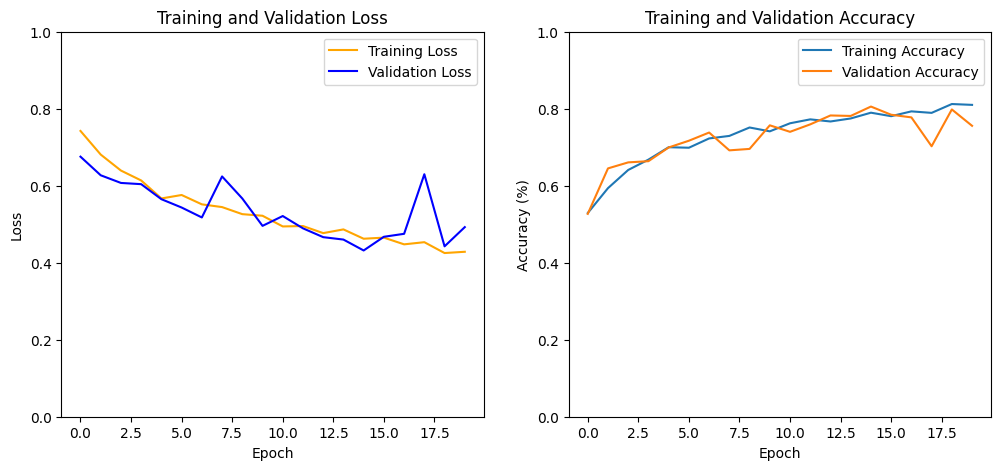

In [15]:
# Plot training loss, accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


In [21]:
# Final accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

print('final accuracy test:', acc[-1])
print('final accuracy validation', val_acc[-1])

final accuracy test: 0.8100000023841858
final accuracy validation 0.7556250095367432


#### **Generate Confusion Matrix**

In [16]:
# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # True labels
    preds = model.predict(images, verbose=0)  # Model predictions
    y_pred.extend((preds > 0.5).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

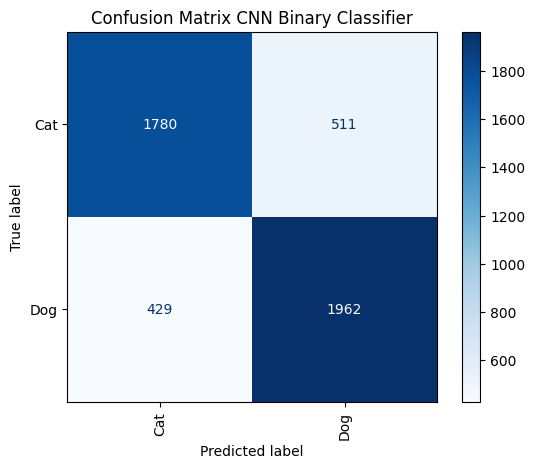

In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix CNN Binary Classifier")
plt.show()

In [22]:
import session_info
session_info.show(html=False)

-----
keras               3.12.0
matplotlib          3.10.7
numpy               2.2.6
session_info        v1.0.1
sklearn             1.7.2
tensorflow          2.20.0
-----
IPython             8.37.0
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.4
-----
Python 3.10.12 (main, Nov  4 2025, 08:48:33) [GCC 11.4.0]
Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35
-----
Session information updated at 2025-12-15 15:47
